<a href="https://colab.research.google.com/github/mokshagna2004/22a31a4270/blob/main/Trader_Behavior_vs_Market_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')
%matplotlib inline


In [2]:
DATA_PATHS = {
    'trades': '/content/historical_data.csv',
    'fear_greed': '/content/fear_greed_index.csv'
}

for k,v in DATA_PATHS.items():
    print(k, '->', Path(v).resolve())


trades -> /content/historical_data.csv
fear_greed -> /content/fear_greed_index.csv


In [3]:
def safe_load_csv(path, **kwargs):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}\nPlease download and place it here or update DATA_PATHS.")
    df = pd.read_csv(path, low_memory=False, **kwargs)
    return df

trades = safe_load_csv(DATA_PATHS['trades'])
fear = safe_load_csv(DATA_PATHS['fear_greed'])

print('Trades shape:', trades.shape)
display(trades.head())
print('\nFear/Greed shape:', fear.shape)
display(fear.head())


Trades shape: (191215, 16)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12



Fear/Greed shape: (2644, 4)


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
def preprocess_trades(df):
    df = df.copy()

    time_cols = [c for c in df.columns if 'time' in c.lower() or 'timestamp' in c.lower() or 'date' in c.lower()]
    print('Detected time-like columns in trades:', time_cols[:5])

    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
    else:

        for c in time_cols:
            df[c] = pd.to_datetime(df[c], errors='coerce')
        if time_cols:
            df['time'] = pd.to_datetime(df[time_cols[0]], errors='coerce')

    df['date'] = df['time'].dt.date

    for col in ['execution price','price','size','closedPnL','closed_pnl','pnl']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def preprocess_fear(df):
    df = df.copy()

    date_cols = [c for c in df.columns if 'date' in c.lower()]
    if 'Date' in df.columns:
        df['date'] = pd.to_datetime(df['Date'], errors='coerce').dt.date
    elif date_cols:
        df['date'] = pd.to_datetime(df[date_cols[0]], errors='coerce').dt.date
    else:

        df.iloc[:,0] = pd.to_datetime(df.iloc[:,0], errors='coerce')
        df['date'] = pd.to_datetime(df.iloc[:,0], errors='coerce').dt.date

    cls_cols = [c for c in df.columns if 'class' in c.lower() or 'fear' in c.lower() or 'greed' in c.lower()]
    if cls_cols:
        df['classification'] = df[cls_cols[0]].astype(str)
    return df

trades = preprocess_trades(trades)
fear = preprocess_fear(fear)

print('After preprocess - trades columns:', trades.columns.tolist()[:30])
print('After preprocess - fear columns:', fear.columns.tolist())


Detected time-like columns in trades: ['Timestamp IST', 'Timestamp']
After preprocess - trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'time', 'date']
After preprocess - fear columns: ['timestamp', 'value', 'classification', 'date']


In [7]:
def compute_metrics(trades):
    t = trades.copy()

    possible_pnl_cols = [c for c in t.columns if any(key in c.lower() for key in ['pnl', 'profit', 'pl'])]
    pnl_col = possible_pnl_cols[0] if possible_pnl_cols else None
    print("Detected PnL column:", pnl_col)

    possible_size_cols = [c for c in t.columns if any(key in c.lower() for key in ['size', 'qty', 'quantity', 'amount', 'volume'])]
    size_col = possible_size_cols[0] if possible_size_cols else None
    print("Detected Size column:", size_col)

    group_cols = []
    for key in ['account', 'user', 'client', 'trader', 'wallet']:
        if key in [c.lower() for c in t.columns]:
            group_cols = [c for c in t.columns if key in c.lower()]
            break
    if not group_cols:
        t['account'] = 'unknown'
        group_cols = ['account']
    print("Grouping by:", group_cols)


    agg_dict = {'date': 'count'}
    if size_col:
        agg_dict[size_col] = lambda x: np.nanmean(pd.to_numeric(x, errors='coerce'))
    if pnl_col:
        agg_dict[pnl_col] = [
            ('win_rate', lambda x: np.mean(pd.to_numeric(x, errors='coerce') > 0)),
            ('avg_pnl', lambda x: np.nanmean(pd.to_numeric(x, errors='coerce')))
        ]


    t['date'] = pd.to_datetime(t['date'], errors='coerce')
    metrics = (
        t.groupby(group_cols)
         .agg(trades_count=('date', 'count'))
         .reset_index()
    )

    if size_col:
        metrics['avg_size'] = t.groupby(group_cols)[size_col].apply(lambda x: np.nanmean(pd.to_numeric(x, errors='coerce'))).values
    if pnl_col:
        pnl_numeric = pd.to_numeric(t[pnl_col], errors='coerce')
        metrics['win_rate'] = t.groupby(group_cols)[pnl_col].apply(lambda x: np.mean(pd.to_numeric(x, errors='coerce') > 0)).values
        metrics['avg_pnl'] = t.groupby(group_cols)[pnl_col].apply(lambda x: np.nanmean(pd.to_numeric(x, errors='coerce'))).values
    else:
        metrics['win_rate'] = np.nan
        metrics['avg_pnl'] = np.nan

    return metrics

metrics = compute_metrics(trades)
display(metrics.head())


Detected PnL column: Closed PnL
Detected Size column: Size Tokens
Grouping by: ['Account']


/tmp/ipython-input-2457872644.py:46: RuntimeWarning: Mean of empty slice
  metrics['avg_size'] = t.groupby(group_cols)[size_col].apply(lambda x: np.nanmean(pd.to_numeric(x, errors='coerce'))).values
/tmp/ipython-input-2457872644.py:50: RuntimeWarning: Mean of empty slice
  metrics['avg_pnl'] = t.groupby(group_cols)[pnl_col].apply(lambda x: np.nanmean(pd.to_numeric(x, errors='coerce'))).values


,Account,trades_count,avg_size,win_rate,avg_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2712,16.167205,0.359612,419.127768
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1730,503.067911,0.442720,6.577654
2,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,4306,2073.877613,0.438585,9.951530
3,0x2c229d22b100a7beb69122eed721cee9b24011dd,896,27144.277189,0.519914,52.071011
4,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,375,7063.480760,0.455215,-38.286626


In [8]:
print(metrics.head())
print(trades.columns.tolist())


                                      Account  trades_count      avg_size  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012          2712     16.167205   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd          1730    503.067911   
2  0x28736f43f1e871e6aa8b1148d38d4994275d72c4          4306   2073.877613   
3  0x2c229d22b100a7beb69122eed721cee9b24011dd           896  27144.277189   
4  0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891           375   7063.480760   

   win_rate     avg_pnl  
0  0.359612  419.127768  
1  0.442720    6.577654  
2  0.438585    9.951530  
3  0.519914   52.071011  
4  0.455215  -38.286626  
['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'time', 'date']


In [9]:
pnl_col = [c for c in trades.columns if any(k in c.lower() for k in ['pnl','profit','pl'])]
pnl_col = pnl_col[0] if pnl_col else None
print("Detected PnL column for merge:", pnl_col)

acct_col = [c for c in trades.columns if any(k in c.lower() for k in ['account','trader','client','user'])]
acct_col = acct_col[0] if acct_col else 'account'

if pnl_col:
    daily = trades.groupby('date').agg(
        daily_trades=(acct_col, 'count'),
        daily_pnl=(pnl_col, lambda x: np.nansum(pd.to_numeric(x, errors='coerce')))
    ).reset_index()
else:
    daily = trades.groupby('date').agg(daily_trades=(acct_col, 'count')).reset_index()

merged = pd.merge(daily, fear[['date', 'classification']], on='date', how='left')
print("Merged shape:", merged.shape)
display(merged.head())


Detected PnL column for merge: Closed PnL
Merged shape: (188, 4)


,date,daily_trades,daily_pnl,classification
0,2023-01-05,3,0.000000,Fear
1,2023-05-12,9,0.000000,Neutral
2,2024-01-01,18,-129.531460,Greed
3,2024-01-02,6,0.000000,Greed
4,2024-01-03,137,8244.241409,Greed


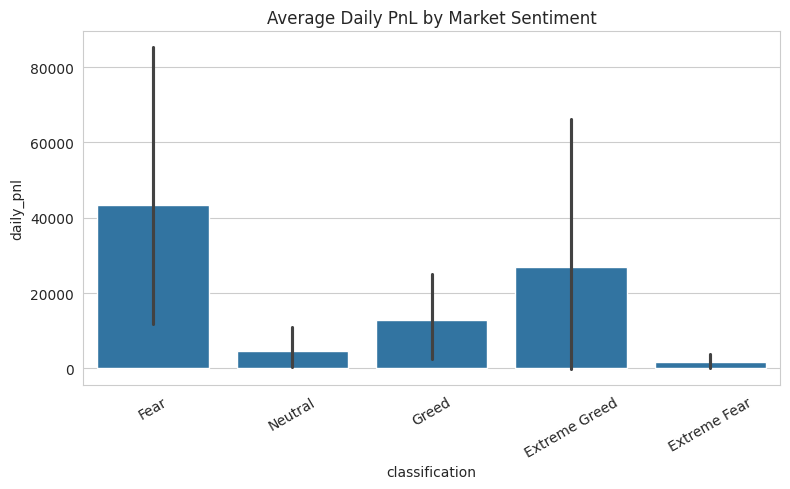

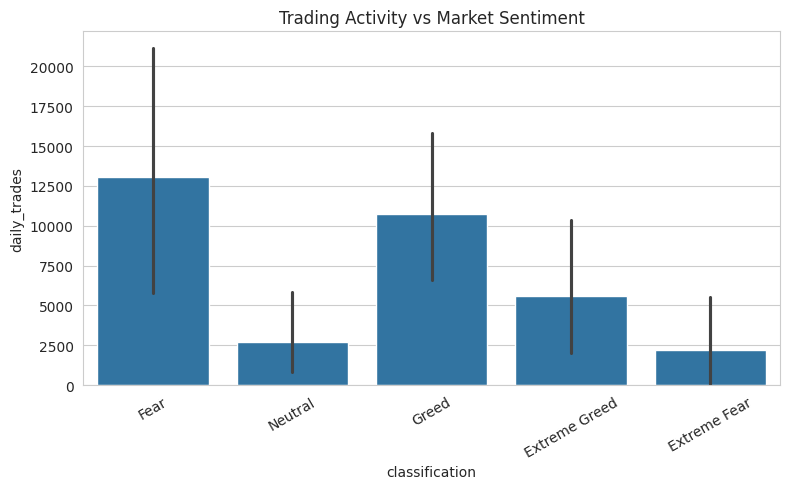

In [12]:
plt.figure(figsize=(8,5))
sns.barplot(data=merged, x='classification', y='daily_pnl', estimator='mean')
plt.title("Average Daily PnL by Market Sentiment")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=merged, x='classification', y='daily_trades', estimator='sum')
plt.title("Trading Activity vs Market Sentiment")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


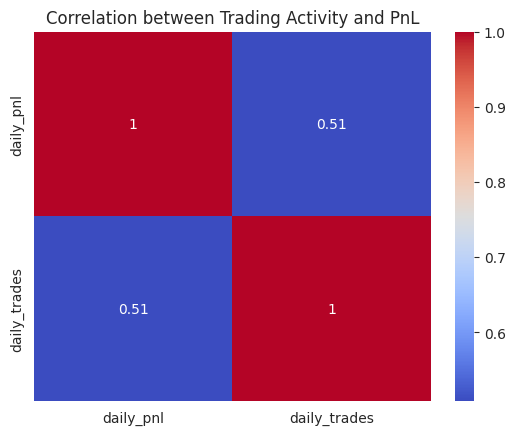

In [11]:
corr = merged[['daily_pnl', 'daily_trades']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Trading Activity and PnL")
plt.show()
